In [1]:
!git clone https://github.com/pashu123/Q-A-chatbot

Cloning into 'Q-A-chatbot'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [2]:
ls

Q-A-chatbot/  sample_data/


In [3]:
cd Q-A-chatbot/

/content/Q-A-chatbot


In [4]:
ls

README.md  test_qa.txt  train_qa.txt


In [0]:
import pickle
import numpy as np

In [0]:
with open('train_qa.txt','rb') as f:
  train_data = pickle.load(f)

In [0]:
with open('test_qa.txt','rb') as f:
  test_data = pickle.load(f)

In [0]:
all_data = test_data + train_data

In [19]:
len(all_data)

11000

In [0]:
vocab = set()
for story,question,answer in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))

In [0]:
vocab.add('no')
vocab.add('yes')

In [24]:
len(vocab)

37

In [0]:
vocab_len = len(vocab)+1

In [26]:
vocab_len

38

In [0]:
all_story_lens = [len(data[0]) for data in all_data]

In [28]:
max(all_story_lens)

156

In [0]:
max_story_len = max(all_story_lens)

In [0]:
max_question_len = max([len(data[1]) for data in all_data])

In [32]:
max_question_len

6

In [33]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(vocab)

In [38]:
len(tokenizer.word_index)

37

In [0]:
train_story_text = []
train_question_text = []
train_answers = []

In [0]:
for story,question,answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
  train_answers.append(answer)

In [0]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [0]:
def vectorize_stories(data,word_index = tokenizer.word_index,max_story_len = max_story_len,max_question_len = max_question_len):
  #stories
  X = []
  #question
  Xq = []
  # Y correct answer
  Y = []
  for story,query,answer in data:
    x = [word_index[word.lower()] for word in story]
    xq = [word_index[word.lower()] for word in query]
    y = np.zeros(len(word_index)+1)
    y[word_index[answer]] = 1
    
    X.append(x)
    Xq.append(xq)
    Y.append(y)
  return (pad_sequences(X,maxlen = max_story_len),pad_sequences(Xq,maxlen = max_question_len),np.array(Y))

In [0]:
inputs_train,queries_train,answers_train = vectorize_stories(train_data)
inputs_test,queries_test,answers_test = vectorize_stories(test_data)

In [51]:
tokenizer.word_index['no']

33

In [0]:
# Build the neural network
## input encoder M
## input encoder C
## question encoder

# Complete the network

In [0]:
from keras.models import Sequential,Model
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [0]:
# placeholder shape = (max_story_len,batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [0]:
# vocab_len
vocab_size = len(vocab)+1

In [0]:
#Input encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim= vocab_size,output_dim = 64))
input_encoder_m.add(Dropout(0.3))

In [0]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim= vocab_size,output_dim = max_question_len))
input_encoder_c.add(Dropout(0.3))

In [0]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim= vocab_size,output_dim = 64,input_length = max_question_len))
question_encoder.add(Dropout(0.3))

#(samples,query_maxlen,embedding_dim)

In [0]:
# Encoded <--- ENCODER(input)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [0]:
match = dot([input_encoded_m,question_encoded],axes = (2,2))
match = Activation('softmax')(match)

In [0]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [0]:
answer = concatenate([response,question_encoded])

In [82]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [0]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

model = Model([input_sequence,question],answer)

In [0]:
model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [87]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       multiple             2432        input_5[0][0]                    
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 6, 64)        2432        input_6[0][0]                    
__________________________________________________________________________________________________
dot_3 (Dot

In [89]:
history = model.fit([inputs_train,queries_train],answers_train,batch_size = 32,epochs = 120,validation_data = ([inputs_test,queries_test],answers_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 8s 782us/step - loss: 0.8897 - acc: 0.4975 - val_loss: 0.6950 - val_acc: 0.4970
Epoch 2/120
10000/10000 [==============================] - 5s 506us/step - loss: 0.7070 - acc: 0.4868 - val_loss: 0.6936 - val_acc: 0.5030
Epoch 3/120
10000/10000 [==============================] - 4s 433us/step - loss: 0.6966 - acc: 0.4927 - val_loss: 0.6932 - val_acc: 0.5030
Epoch 4/120
10000/10000 [==============================] - 4s 434us/step - loss: 0.6943 - acc: 0.5031 - val_loss: 0.6936 - val_acc: 0.5030
Epoch 5/120
10000/10000 [==============================] - 4s 434us/step - loss: 0.6945 - acc: 0.5039 - val_loss: 0.6953 - val_acc: 0.4970
Epoch 6/120
10000/10000 [==============================] - 5s 465us/step - loss: 0.6946 - acc: 0.5024 - val_loss: 0.6934 - val_acc

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


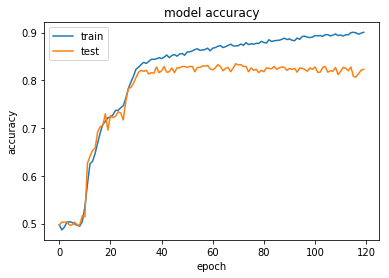

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [0]:
model.save('rnnmodel_120.h5')

In [0]:
pred_results = model.predict(([inputs_test,queries_test]))

In [93]:
pred_results.shape

(1000, 38)

In [94]:
pred_results[0]

array([5.9477611e-16, 7.1023988e-16, 7.7979891e-16, 7.1663005e-16,
       5.9055513e-16, 5.5009898e-16, 6.0564920e-16, 5.8229163e-16,
       6.0195238e-16, 7.0490362e-16, 5.5905599e-16, 5.7672303e-16,
       6.1828529e-16, 6.5682345e-04, 6.1178643e-16, 6.0466585e-16,
       6.1348781e-16, 7.1645779e-16, 5.9472391e-16, 6.0285553e-16,
       6.3483118e-16, 5.1520530e-16, 6.5601564e-16, 6.7771567e-16,
       7.1167454e-16, 6.4232171e-16, 6.3588547e-16, 5.8803738e-16,
       5.9262231e-16, 6.3359970e-16, 5.8176325e-16, 6.3196556e-16,
       5.9876452e-16, 9.9934322e-01, 6.7142401e-16, 6.7776215e-16,
       6.4993039e-16, 6.2589329e-16], dtype=float32)

In [0]:
val_max = np.argmax(pred_results[0])

In [96]:
val_max

33

In [0]:
for key,val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [98]:
k

'no'

In [99]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [105]:
my_story = "John left the kitchen . Sandra dropped the football in the garden . "
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [106]:
my_question = "Is the football in the garden ?"
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [0]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [0]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [0]:
pred_result = model.predict(([my_story,my_ques]))

In [0]:
val_max = np.argmax(pred_result[0])

In [0]:
for key,val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [112]:
k

'yes'